In [2]:
##Importing Libraries

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from  tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

In [28]:
data_cab = pd.read_csv('./dataset/Cab_Data.csv')
data_customer = pd.read_csv('./dataset/Customer_ID.csv')
data_transaction = pd.read_csv('./dataset/Transaction_ID.csv')
data_city = pd.read_csv('./dataset/City.csv')

In [196]:
print(data_cab.isnull().sum(),
data_customer.isnull().sum(),
data_transaction.isnull().sum(),
data_city.isnull().sum())

Transaction ID    0
Date of Travel    0
Company           0
City              0
KM Travelled      0
Price Charged     0
Cost of Trip      0
Months            0
Years             0
dtype: int64 Customer ID           0
Gender                0
Age                   0
Income (USD/Month)    0
dtype: int64 Transaction ID    0
Customer ID       0
Payment_Mode      0
dtype: int64 City          0
Population    0
Users         0
dtype: int64


### NO NULL VALUES

#### Shape of all the dataframes

In [7]:
print("Cab Shape", data_cab.shape, "\nCustomer Shape", data_customer.shape, "\nTransaction Shape", data_transaction.shape, "\nCity Shape", data_city.shape)

Cab Shape (359392, 7) 
Customer Shape (49171, 4) 
Transaction Shape (440098, 3) 
City Shape (20, 3)


#### Column names

In [8]:
print("Columns :", "\nCity Columns", data_city.columns, "\nCustomer Columns", data_customer.columns, "\nTransaction Columns ",data_transaction.columns)

Columns : 
City Columns Index(['City', 'Population', 'Users'], dtype='object') 
Customer Columns Index(['Customer ID', 'Gender', 'Age', 'Income (USD/Month)'], dtype='object') 
Transaction Columns  Index(['Transaction ID', 'Customer ID', 'Payment_Mode'], dtype='object')


#### Correcting Date Field

In [29]:
data_cab['temp']= data_cab.groupby('Date of Travel')['Date of Travel'].cumcount()
data_cab.sort_values(by=[ 'Date of Travel', 'temp'], inplace=True, ascending = True,ignore_index= False)
data_cab.drop('temp', axis=1, inplace=True)
data_cab['Date of Travel'] = pd.to_datetime(data_cab['Date of Travel'],origin="1899-12-30", unit = 'D')
data_cab = data_cab.reset_index(drop=True)

#### Months and years from date field   

In [16]:
months =[]
#days = []
years = []
for i in tqdm(range(len(data_cab))):
    months.append(data_cab.loc[i]['Date of Travel'].month)
    #days.append(data_cab.loc[i]['Date of Travel'].day)
    years.append(data_cab.loc[i]['Date of Travel'].year)

    

100%|████████████████████████████████████████████████████████████████████████| 359392/359392 [03:37<00:00, 1654.40it/s]


In [30]:
data_cab['Months'] = months
#data_cab['Days'] = days
data_cab['Years'] = years

#### Calculating Profit of both Companies

In [32]:
#merging tables and creating master data

df = data_cab.merge(data_transaction, on='Transaction ID', how='left')\
                .merge(data_customer, on='Customer ID', how='left')\
                #.merge(data_city, on='City', how='left')

In [33]:
df = df.rename({'KM Travelled' : 'KM_Travelled',
                'Transaction ID' : 'Transaction_ID',
          'Price Charged' : 'Price_Charged',
          'Cost of Trip'  : 'Cost_of_Trip',
          'Date of Travel': 'Date_of_Travel'},axis = 1) #Renaming Column names

In [35]:
df['Profit']  = abs(df['Cost_of_Trip'] - df['Price_Charged'])

In [36]:
profits ={}
profits["PinkCab"] = {}
profits["YellowCab"] = {}
profits["PinkCab"]["2016"] = df[(df['Company'] == "Pink Cab") & (df['Years'] == 2016)]['Profit'].sum()
profits['PinkCab']["2017"] = df[(df['Company'] == "Pink Cab") & (df['Years'] == 2017)]['Profit'].sum()
profits['PinkCab'] ["2018"] = df[(df['Company'] == "Pink Cab") & (df['Years'] == 2018)]['Profit'].sum()
profits["YellowCab"]["2016"] = df[(df['Company'] == "Yellow Cab") & (df['Years'] == 2016)]['Profit'].sum()
profits['YellowCab']["2017"] = df[(df['Company'] == "Yellow Cab") & (df['Years'] == 2017)]['Profit'].sum()
profits['YellowCab'] ["2018"] = df[(df['Company'] == "Yellow Cab") & (df['Years'] == 2018)]['Profit'].sum()

In [38]:
for company,year in profits.items():
    for yea, profit in year.items():
        print(f"{yea} {company}'s Profit  {round(profit,2)}")
    if company == "YellowCab" : 
        print(f"{company} 's Total Profit is {round(sum(year.values()),2)}")
    elif company == "PinkCab" : 
        print(f"{company} 's Total Profit is {round(sum(year.values()),2)}")
        print("\n")


2016 PinkCab's Profit  1855912.39
2017 PinkCab's Profit  2224041.71
2018 PinkCab's Profit  1680718.64
PinkCab 's Total Profit is 5760672.74


2016 YellowCab's Profit  14083070.63
2017 YellowCab's Profit  16788334.65
2018 YellowCab's Profit  13667164.93
YellowCab 's Total Profit is 44538570.21


#### Bifergating data into two df as per comapny

In [39]:
df_pink= df[df['Company'] == 'Pink Cab']
df_pink = df_pink.drop('Company', axis = 1)


In [40]:
df_yellow = df[df['Company'] == 'Yellow Cab']
df_yellow = df_yellow.drop('Company', axis = 1)

#### Correaltion in variables

In [41]:
print(df_pink.corr()['Price_Charged'].abs().sort_values(ascending=False)[1:])
print("\n")
print(df_yellow.corr()['Price_Charged'].abs().sort_values(ascending=False)[1:])


KM_Travelled          0.927765
Cost_of_Trip          0.921896
Profit                0.773518
Customer ID           0.056342
Years                 0.030985
Months                0.027243
Transaction ID        0.016311
Age                   0.006657
Income (USD/Month)    0.002075
Name: Price_Charged, dtype: float64


Profit                0.875868
KM_Travelled          0.859709
Cost_of_Trip          0.853996
Customer ID           0.208935
Months                0.066657
Transaction ID        0.058665
Years                 0.038357
Income (USD/Month)    0.003818
Age                   0.002721
Name: Price_Charged, dtype: float64


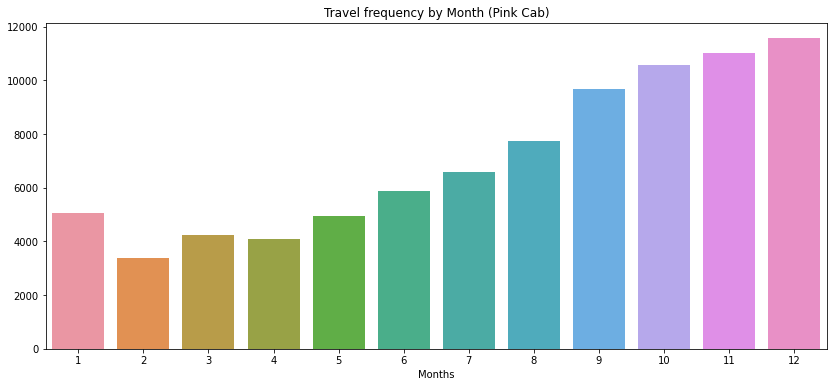

In [48]:
plot0 = df[df.Company=='Pink Cab'].groupby(['Months']).Transaction_ID.count()
plt.figure(figsize=(14,6))
sns.barplot(x=plot0.index,y=plot0.values)
plt.title('Travel frequency by Month (Pink Cab)')
plt.show()

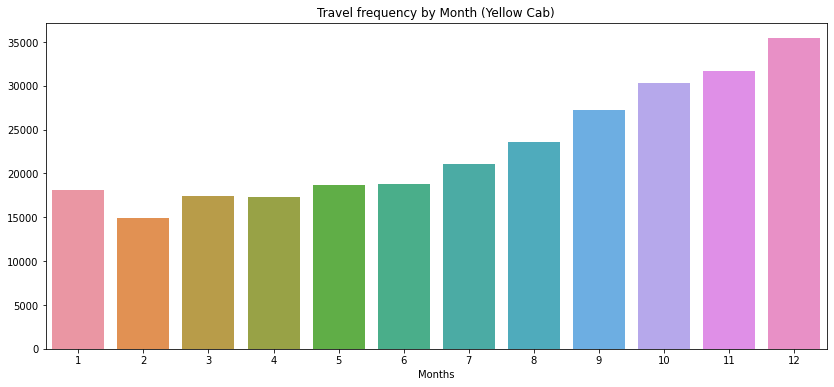

In [51]:
plot10 = df[df.Company=='Yellow Cab'].groupby(['Months']).Transaction_ID.count()
plt.figure(figsize=(14,6))
sns.barplot(x=plot10.index,y=plot10.values)
plt.title('Travel frequency by Month (Yellow Cab)')
plt.show()

Yellow cab have more travels than Pink cab

In [54]:
total_distance = df['KM_Travelled'].describe()
pink_distance = df_pink['KM_Travelled'].describe()
yellow_distance = df_yellow['KM_Travelled'].describe()

In [56]:
pd.DataFrame({'Overall': total_distance.values,
                  'PinkCab': pink_distance.values,
                  'YellowCab': yellow_distance.values}, index= ['Count', 'Mean', 'Std. Dev.', 'Min', '25%', '50%', '75%', 'Max'])

,Overall,PinkCab,YellowCab
Count,359392.000000,84711.000000,274681.000000
Mean,22.567254,22.559917,22.569517
Std. Dev.,12.233526,12.231092,12.234298
Min,1.900000,1.900000,1.900000
25%,12.000000,12.000000,11.990000
50%,22.440000,22.440000,22.440000
75%,32.960000,32.960000,32.960000
Max,48.000000,48.000000,48.000000


Text(0, 0.5, 'frequency')

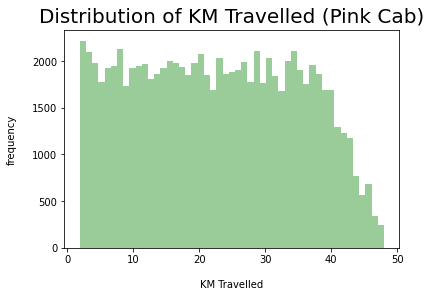

In [60]:
ax = sns.distplot(df_pink['KM_Travelled'], kde=False, color='green')
plt.title("Distribution of KM Travelled (Pink Cab)", fontsize=20, y=1.012)
plt.xlabel("KM Travelled", labelpad=15)
plt.ylabel("frequency", labelpad=15)



Text(0, 0.5, 'frequency')

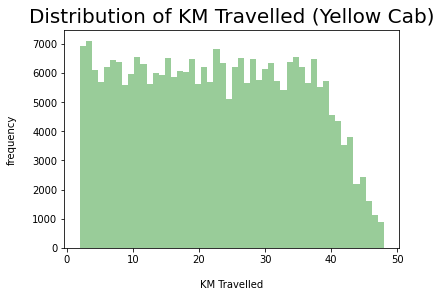

In [62]:
ax = sns.distplot(df_yellow['KM_Travelled'], kde=False, color='green')
plt.title("Distribution of KM Travelled (Yellow Cab)", fontsize=20, y=1.012)
plt.xlabel("KM Travelled", labelpad=15)
plt.ylabel("frequency", labelpad=15)

From the above graphs, we can see that most of the rides are in the range of approximately 2 to 48 KM.

No handles with labels found to put in legend.


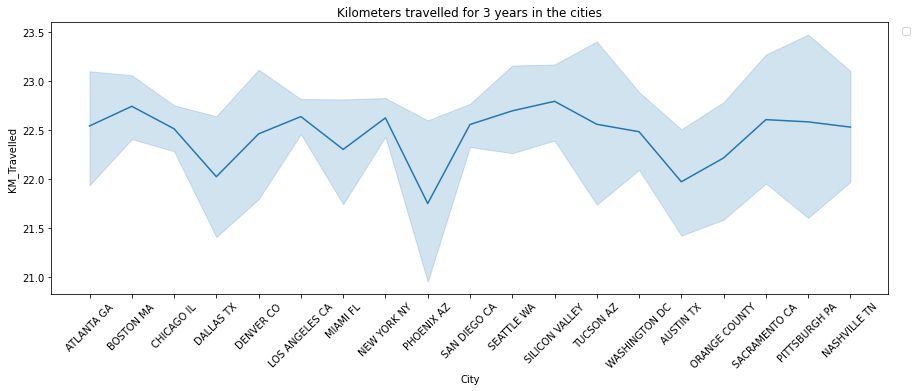

In [63]:
plt.figure(figsize=(15,5))
ln = sns.lineplot(data=df_pink, y="KM_Travelled", x="City")
ln.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.title("Kilometers travelled for 3 years in the cities") #more over we can change the year and find accordingly 
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.show()

C:\Users\Anirudh\.conda\envs\trial\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Anirudh\.conda\envs\trial\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Yellow Cab')

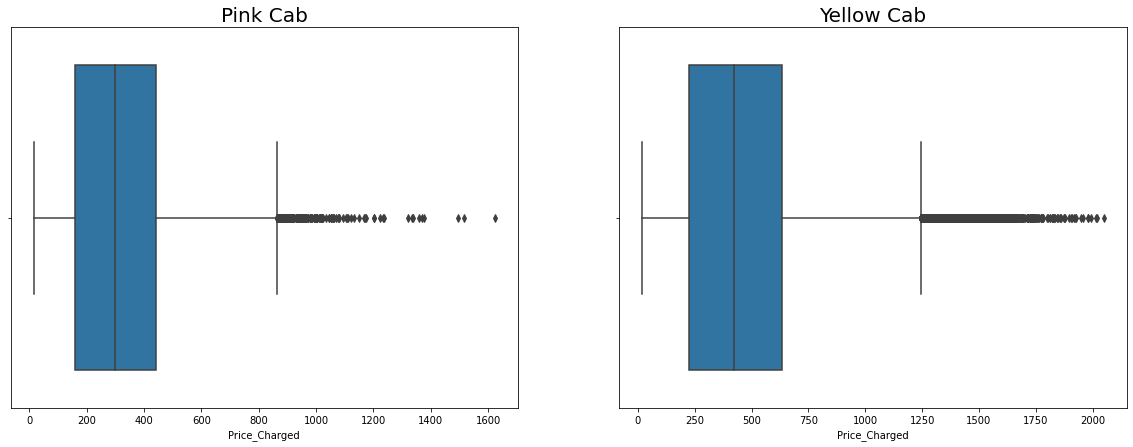

In [65]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,7))
sns.boxplot(df_pink['Price_Charged'], ax=ax1)
ax1.set_title('Pink Cab', fontsize=20)
sns.boxplot(df_yellow['Price_Charged'], ax=ax2)
ax2.set_title('Yellow Cab', fontsize=20)

#Outliers
#These outliers are due to use of high-end cars so decided to keep it.
#The price charge range for Yellow cab is more than the Pink cab.

C:\Users\Anirudh\.conda\envs\trial\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Anirudh\AppData\Local\Temp/ipykernel_12596/817575370.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, fontsize=15)
C:\Users\Anirudh\.conda\envs\trial\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Anirudh\AppData\Local\Temp/ipykernel_12596/817575370.py:7: UserWarning: FixedFormatter should only be used

[Text(-10.0, 0, ''),
 Text(0.0, 0, ''),
 Text(10.0, 0, ''),
 Text(20.0, 0, ''),
 Text(30.0, 0, ''),
 Text(40.0, 0, ''),
 Text(50.0, 0, ''),
 Text(60.0, 0, '')]

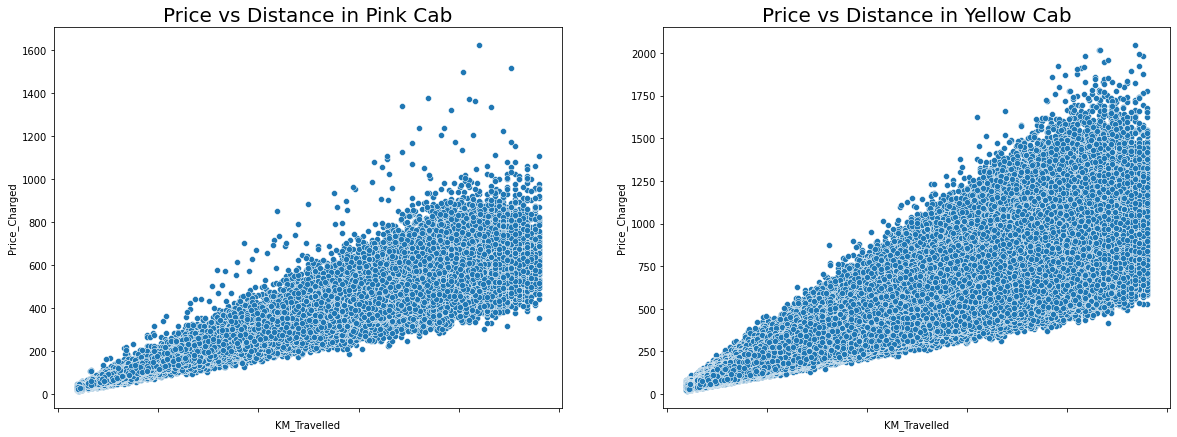

In [67]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
sns.scatterplot(df_pink['KM_Travelled'], df_pink['Price_Charged'], ax=ax1)
ax1.set_title('Price vs Distance in Pink Cab', fontsize=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, fontsize=15)
sns.scatterplot(df_yellow['KM_Travelled'], df_yellow['Price_Charged'], ax=ax2)
ax2.set_title('Price vs Distance in Yellow Cab', fontsize=20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, fontsize=15)

In [69]:
df_pink['KM_Travelled'].corr(df_pink['Price_Charged'])

0.927765278259487

In [71]:
df_yellow['KM_Travelled'].corr(df_yellow['Price_Charged'])

0.8597086294478476

Distance is one of the important factors, which drives the price of the rides. 


In [79]:
df_pink.columns

Index(['Transaction ID', 'Date_of_Travel', 'City', 'KM_Travelled',
       'Price_Charged', 'Cost_of_Trip', 'Months', 'Years', 'Customer ID',
       'Payment_Mode', 'Gender', 'Age', 'Income (USD/Month)', 'Profit'],
      dtype='object')

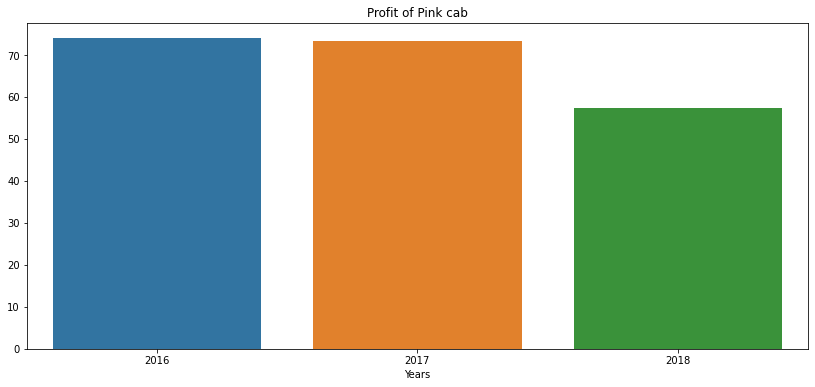

In [83]:
plot = df_pink.groupby('Years').Profit.mean()
plt.figure(figsize=(14,6))
sns.barplot(x=plot.index,y=plot.values)
plt.title('Profit of Pink cab')
plt.show()

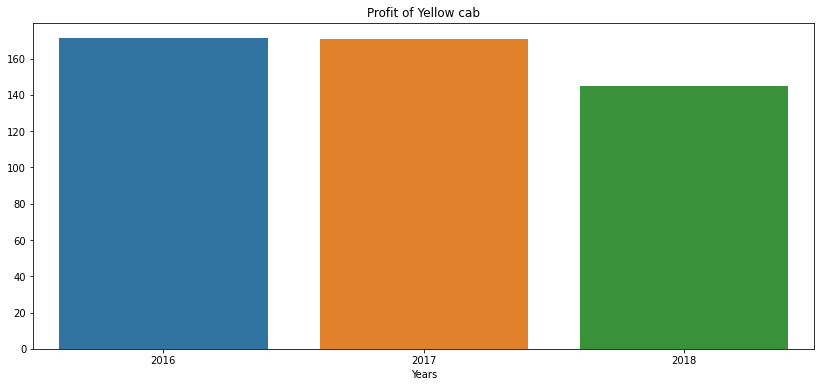

In [86]:
plot = df_yellow.groupby('Years').Profit.mean()
plt.figure(figsize=(14,6))
sns.barplot(x=plot.index,y=plot.values)
plt.title('Profit of Yellow cab')
plt.show()

Yellow have more profit in all the three years

Text(0.5, 0, 'Pink Cab KM Travelled')

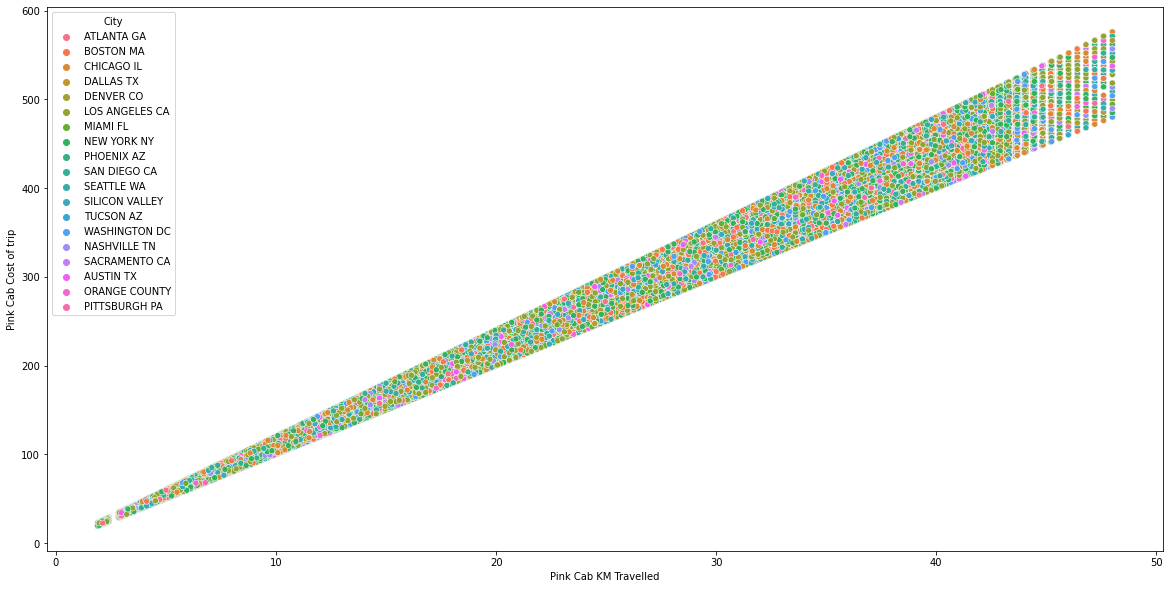

In [85]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df, x=df_pink["KM_Travelled"], y=df_pink['Cost_of_Trip'], hue="City")
plt.ylabel('Pink Cab Cost of trip')
plt.xlabel('Pink Cab KM Travelled')

Text(0.5, 0, 'Yellow Cab KM Travelled')

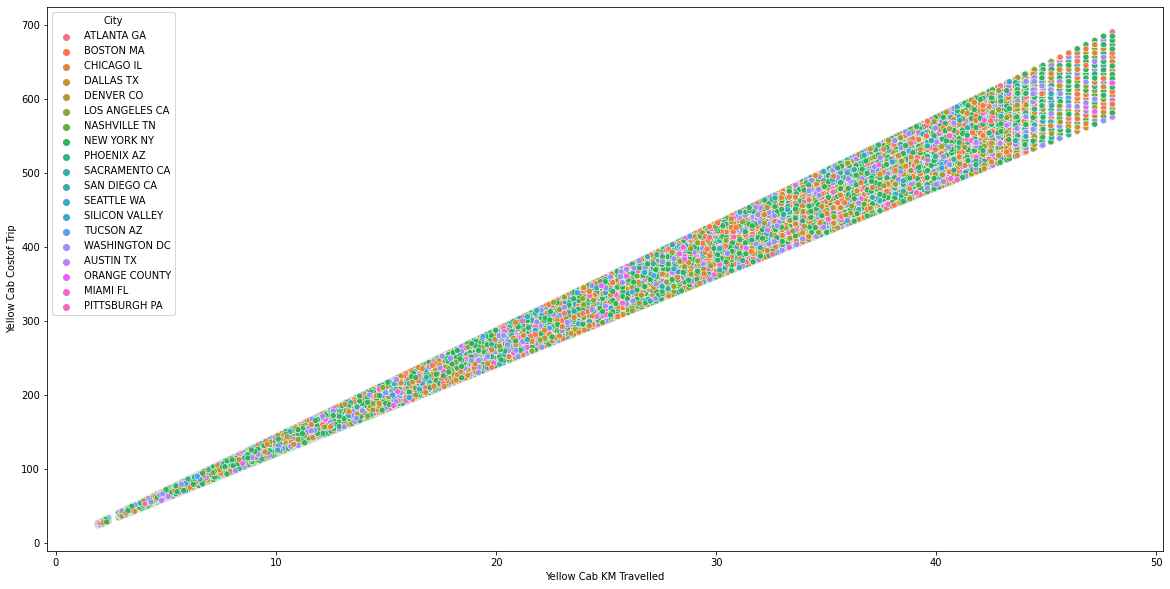

In [87]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=df_yellow, x=df_yellow["KM_Travelled"], y=df_yellow['Cost_of_Trip'], hue="City")
plt.ylabel('Yellow Cab Costof Trip')
plt.xlabel('Yellow Cab KM Travelled')


From the graph we see that the cost of trip for both Pink and Yellow cab are almost the same.


In [88]:
df

,Transaction_ID,Date_of_Travel,Company,City,KM_Travelled,Price_Charged,Cost_of_Trip,Months,Years,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Profit
0,10000013,2016-01-02,Pink Cab,ATLANTA GA,9.04,125.20,97.6320,1,2016,28712,Cash,Male,53,11242,27.5680
1,10000029,2016-01-02,Pink Cab,BOSTON MA,21.34,324.21,226.2040,1,2016,58925,Card,Male,38,26550,98.0060
2,10000030,2016-01-02,Pink Cab,BOSTON MA,41.30,646.06,454.3000,1,2016,58551,Card,Male,25,21734,191.7600
3,10000041,2016-01-02,Pink Cab,CHICAGO IL,35.02,598.43,406.2320,1,2016,4289,Card,Male,19,28719,192.1980
4,10000045,2016-01-02,Pink Cab,CHICAGO IL,3.24,48.04,33.6960,1,2016,5734,Card,Male,23,22475,14.3440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359387,10439960,2018-12-31,Yellow Cab,WASHINGTON DC,33.93,474.47,411.2316,12,2018,52449,Card,Female,40,23569,63.2384
359388,10439984,2018-12-31,Yellow Cab,WASHINGTON DC,40.00,641.78,484.8000,12,2018,51614,Card,Female,55,12279,156.9800
359389,10440028,2018-12-31,Yellow Cab,WASHINGTON DC,26.22,405.25,327.2256,12,2018,52389,Card,Female,29,5568,78.0244
359390,10440034,2018-12-31,Yellow Cab,WASHINGTON DC,34.68,505.38,470.2608,12,2018,51877,Cash,Male,46,16993,35.1192


In [91]:
df.columns

Index(['Transaction_ID', 'Date_of_Travel', 'Company', 'City', 'KM_Travelled',
       'Price_Charged', 'Cost_of_Trip', 'Months', 'Years', 'Customer ID',
       'Payment_Mode', 'Gender', 'Age', 'Income (USD/Month)', 'Profit'],
      dtype='object')

In [92]:
df = df.rename({'Customer ID' : 'Customer_ID'},axis = 1)

In [93]:
df.set_index(['Transaction_ID','Customer_ID','City'])

,,,Date_of_Travel,Company,KM_Travelled,Price_Charged,Cost_of_Trip,Months,Years,Payment_Mode,Gender,Age,Income (USD/Month),Profit
Transaction_ID,Customer_ID,City,,,,,,,,,,,,
10000013,28712,ATLANTA GA,2016-01-02,Pink Cab,9.04,125.20,97.6320,1,2016,Cash,Male,53,11242,27.5680
10000029,58925,BOSTON MA,2016-01-02,Pink Cab,21.34,324.21,226.2040,1,2016,Card,Male,38,26550,98.0060
10000030,58551,BOSTON MA,2016-01-02,Pink Cab,41.30,646.06,454.3000,1,2016,Card,Male,25,21734,191.7600
10000041,4289,CHICAGO IL,2016-01-02,Pink Cab,35.02,598.43,406.2320,1,2016,Card,Male,19,28719,192.1980
10000045,5734,CHICAGO IL,2016-01-02,Pink Cab,3.24,48.04,33.6960,1,2016,Card,Male,23,22475,14.3440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10439960,52449,WASHINGTON DC,2018-12-31,Yellow Cab,33.93,474.47,411.2316,12,2018,Card,Female,40,23569,63.2384
10439984,51614,WASHINGTON DC,2018-12-31,Yellow Cab,40.00,641.78,484.8000,12,2018,Card,Female,55,12279,156.9800
10440028,52389,WASHINGTON DC,2018-12-31,Yellow Cab,26.22,405.25,327.2256,12,2018,Card,Female,29,5568,78.0244


In [95]:
df = data_cab.merge(data_city, on='City', how='left')

In [96]:

city_users = df.groupby('City').Users.count()
city_users

City
ATLANTA GA         7557
AUSTIN TX          4896
BOSTON MA         29692
CHICAGO IL        56625
DALLAS TX          7017
DENVER CO          3825
LOS ANGELES CA    48033
MIAMI FL           6454
NASHVILLE TN       3010
NEW YORK NY       99885
ORANGE COUNTY      3982
PHOENIX AZ         2064
PITTSBURGH PA      1313
SACRAMENTO CA      2367
SAN DIEGO CA      20488
SEATTLE WA         7997
SILICON VALLEY     8519
TUCSON AZ          1931
WASHINGTON DC     43737
Name: Users, dtype: int64

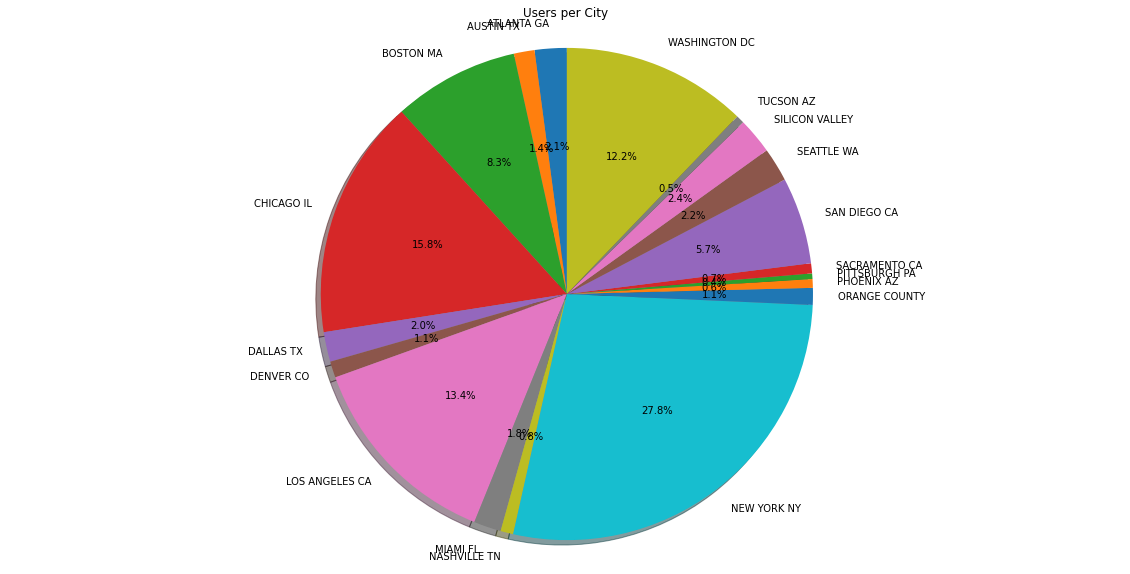

In [97]:
labs = city_users.index
vals = city_users.values
figp, axp = plt.subplots(figsize=(20,10))
axp.pie(vals , labels=labs, autopct='%1.1f%%',shadow=True, startangle=90,)
axp.axis('equal')

plt.title('Users per City')
plt.show()

New York City has the highest Cab users with 28% followed by Chicago with 16% and Los Angeles with 13%


### Counting of Profits


Text(0.5, 1.0, 'Count of Payment Mode for Pink Cab')

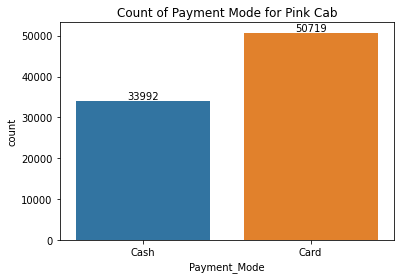

In [104]:
#count of cash and card for both companies
ax = sns.countplot(data=df_pink,x="Payment_Mode")
ax.bar_label(ax.containers[0])
plt.title("Count of Payment Mode for Pink Cab")

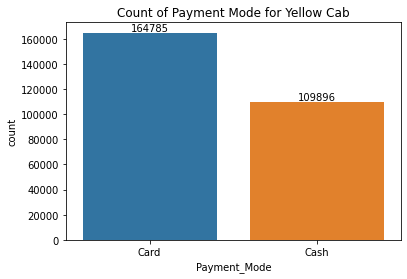

In [105]:
ax = sns.countplot(data=df_yellow,x="Payment_Mode")
ax.bar_label(ax.containers[0])
plt.title("Count of Payment Mode for Yellow Cab")
plt.show()

<AxesSubplot:xlabel='Date_of_Travel', ylabel='Profit'>

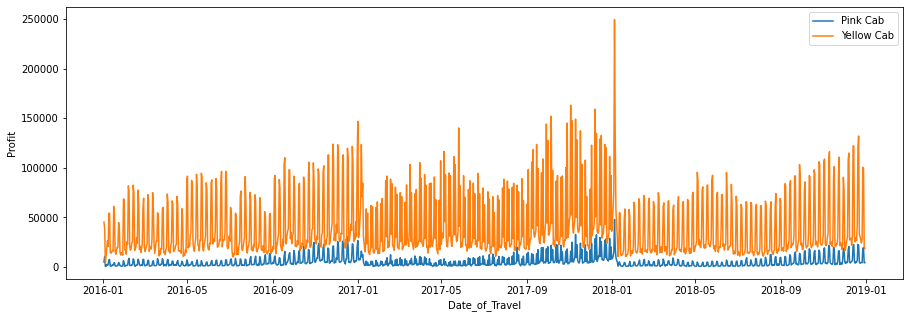

In [109]:
df_pink_profit = df_pink.groupby(df_pink['Date_of_Travel'])['Profit'].sum().reset_index()
df_yellow_profit = df_yellow.groupby(df_yellow['Date_of_Travel'])['Profit'].sum().reset_index()
plt.figure(figsize=(15,5))
sns.lineplot(data=df_pink_profit, x = "Date_of_Travel", y= "Profit", label = "Pink Cab")
sns.lineplot(data=df_yellow_profit, x = "Date_of_Travel", y= "Profit", label = "Yellow Cab")


Profit comparision of both the companies

#### Company Correlation

In [115]:
df['Margins'] = (df['Price Charged']-df['Cost of Trip'])


In [118]:
df = df.drop('Transaction ID',axis = 1)

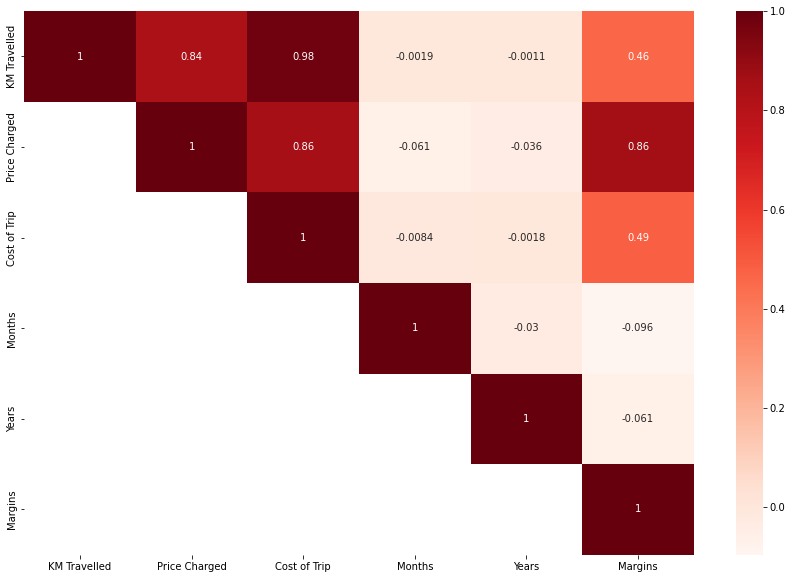

In [119]:
plt.figure(figsize=(15,10))
corr_m = df.corr()
x = np.tri(corr_m.shape[0],k=-1)
sns.heatmap(corr_m, annot=True, cmap=plt.cm.Reds, mask=x)
plt.show()

There is a correlation between Margin & Price Charged

#### Pink Company Coorelation

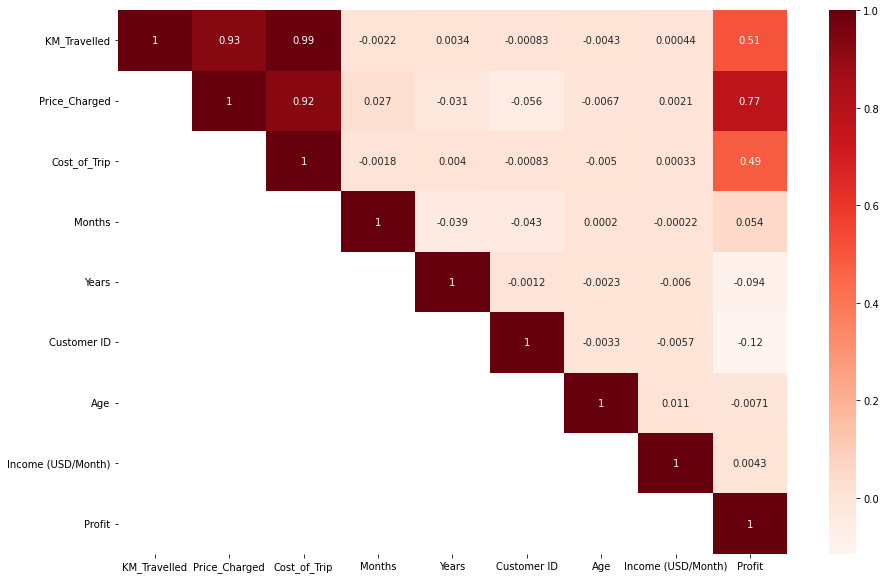

In [128]:
plt.figure(figsize=(15,10))
corr_m = df_pink.drop('Transaction ID',axis = 1).corr()
x = np.tri(corr_m.shape[0],k=-1)
sns.heatmap(corr_m, annot=True, cmap=plt.cm.Reds, mask=x)
plt.show()

#### Yellow company cooreation

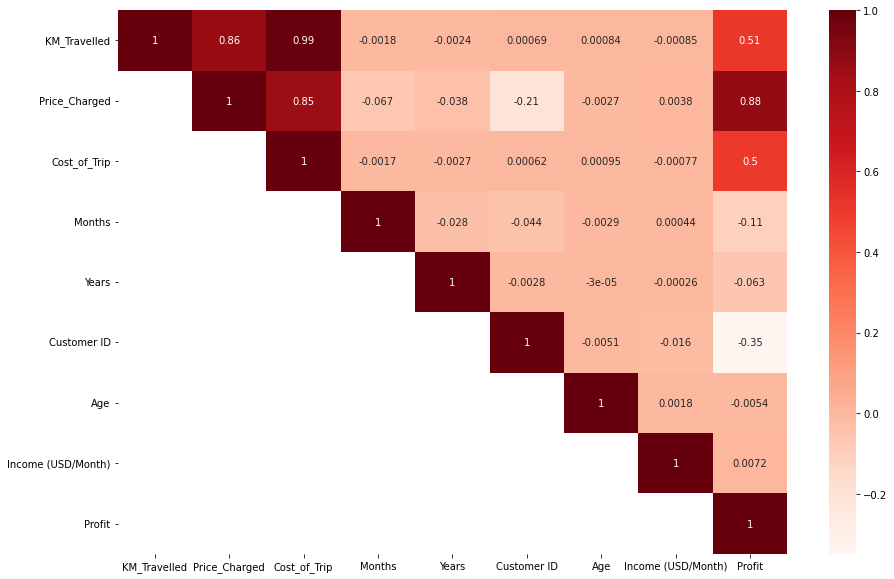

In [131]:
plt.figure(figsize=(15,10))
corr_m = df_yellow.drop('Transaction ID',axis = 1).corr()
x = np.tri(corr_m.shape[0],k=-1)
sns.heatmap(corr_m, annot=True, cmap=plt.cm.Reds, mask=x)
plt.show()

<AxesSubplot:xlabel='Transaction ID', ylabel='Profit'>

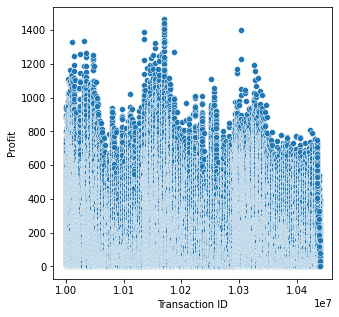

In [124]:
plt.figure(figsize=(5,5))
sns.scatterplot(x=df_yellow["Transaction ID"],y=df_yellow["Profit"])

Yellow Cab decrease the Margin with the increase in Transaction


<AxesSubplot:xlabel='Transaction ID', ylabel='Profit'>

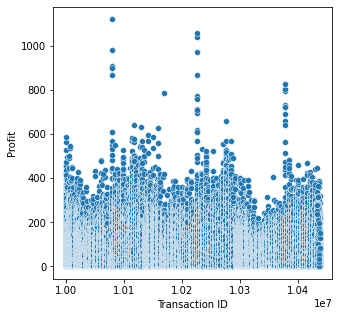

In [123]:
plt.figure(figsize=(5,5))
sns.scatterplot(x=df_pink["Transaction ID"],y=df_pink["Profit"])

Pink Cabs increase their margins with increase in number of Transactions


## ML algorithms

#### Yellow company

In [145]:
data_yellow_X = df_yellow[["KM_Travelled","Price_Charged","Cost_of_Trip","Months", "Years", "Gender","Age","Income (USD/Month)"]]

In [146]:
gender_dummy = pd.get_dummies(data_yellow_X.Gender)
years_dummy = pd.get_dummies(data_yellow_X.Years)
months_dummy = pd.get_dummies(data_yellow_X.Months)


In [147]:
data_yellow_X = pd.concat([data_yellow_X, gender_dummy,years_dummy, months_dummy],axis = 1) 

In [148]:
data_yellow_X = data_yellow_X.drop(["Years" ,"Gender", "Months"], axis = 1)

In [149]:
data_yellow_y = pd.DataFrame(df_yellow["Profit"].copy())

In [150]:
X_train,X_test,y_train, y_test = train_test_split(data_yellow_X,data_yellow_y,test_size = 0.2,random_state = 42)

In [151]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
train_pred = lin_reg.predict(X_train)
print(f'Train score {np.sqrt(mean_squared_error(y_train, train_pred))}')

predicted = lin_reg.predict(X_test)
print(f'Test score {np.sqrt(mean_squared_error(y_test, predicted))}')
print('The accuracy of Yellow company model is: ' + str(lin_reg.score(X_train,y_train) *100) + '%')

Train score 11.701885366898596
Test score 11.534399501370077
The accuracy of Yellow company model is: 99.52722532204236%


#### Pink company model

In [153]:
data_pink_X = df_pink[["KM_Travelled","Price_Charged","Cost_of_Trip","Months", "Years", "Gender","Age","Income (USD/Month)"]]

In [154]:
gender_dummy = pd.get_dummies(data_pink_X.Gender)
years_dummy = pd.get_dummies(data_pink_X.Years)
months_dummy = pd.get_dummies(data_pink_X.Months)
data_pink_X = pd.concat([data_pink_X, gender_dummy,years_dummy, months_dummy],axis = 1) 
data_pink_X = data_pink_X.drop(["Years" ,"Gender", "Months"], axis = 1)

In [155]:
data_pink_y = pd.DataFrame(df_pink["Profit"].copy())

In [156]:
X_train,X_test,y_train, y_test = train_test_split(data_pink_X,data_pink_y,test_size = 0.2,random_state = 42)

In [157]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
train_pred = lin_reg.predict(X_train)
print(f'Train score {np.sqrt(mean_squared_error(y_train, train_pred))}')

predicted = lin_reg.predict(X_test)
print(f'Test score {np.sqrt(mean_squared_error(y_test, predicted))}')
print('The accuracy of Yellow company model is: ' + str(lin_reg.score(X_train,y_train) *100) + '%')

Train score 18.53754928441933
Test score 18.597158084770477
The accuracy of Yellow company model is: 93.53330145856755%


#### Yellow company Decision tree

In [158]:
X_trainu, X_testu, y_trainu, y_testu = train_test_split(data_yellow_X, data_yellow_y, test_size=0.3, random_state=42)


In [159]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_curve
dtree = DecisionTreeRegressor()

dtree.fit(X_trainu, y_trainu)

train_pred = dtree.predict(X_trainu)

tr_rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
print(f'Train score : {tr_rmse}')
predicted = dtree.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

Train score : 5.200829638523178e-16
Test score : 2.4365192812993866


#### pink company Decision tree

In [162]:
X_trainu, X_testu, y_trainu, y_testu = train_test_split(data_pink_X, data_pink_y, test_size=0.3, random_state=42)


In [163]:
dtree.fit(X_trainu, y_trainu)

train_pred = dtree.predict(X_trainu)

tr_rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
print(f'Train score : {tr_rmse}')
predicted = dtree.predict(X_testu)
rmse = np.sqrt(mean_squared_error(y_testu, predicted))
print(f'Test score : {rmse}')

Train score : 4.622859598865224e-16
Test score : 4.425161541411206


In [170]:
max_depth = range(1,20)
train_results = []
test_results = []
for n in tqdm(max_depth):
    dt = DecisionTreeRegressor(max_depth=n)
    dt.fit(X_trainu, y_trainu)
    train_pred = dt.predict(X_trainu)
    rmse = np.sqrt(mean_squared_error(y_trainu, train_pred))
    train_results.append(rmse)
    y_pred = dt.predict(X_testu)
    ts_rmse = np.sqrt(mean_squared_error(y_testu, y_pred))
    test_results.append(ts_rmse)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:09<00:00,  2.07it/s]


In [181]:
train_results

[53.727155855135095,
 44.08114118242952,
 38.68665468809317,
 31.192318931515636,
 25.333655042779284,
 19.236463003964936,
 15.337319392125075,
 11.378519507825688,
 9.048469253786452,
 6.78174536629857,
 5.269817831099202,
 4.2412058200872,
 3.110434741363715,
 2.4853673910093756,
 1.925119952051382,
 1.5207875068469976,
 1.1954499134155159,
 0.9928382797416075,
 0.7942663390485494]

In [182]:
test_results

[54.510626318870266,
 44.39910353029406,
 39.22251370861243,
 31.705218347935514,
 25.880556268572583,
 19.915457725623913,
 15.97366714498966,
 12.166982261215109,
 10.180593584329554,
 8.127778297701596,
 6.5339937755725295,
 6.052446390849469,
 5.308272731085678,
 4.527418987331593,
 4.579319916250896,
 4.647757233507401,
 4.363426109235858,
 4.089710895471297,
 4.420630561355513]

In [191]:
data4

,City,Population,Users
0,NEW YORK NY,"8,405,837","302,149"
1,CHICAGO IL,"1,955,130","164,468"
2,LOS ANGELES CA,"1,595,037","144,132"
3,MIAMI FL,"1,339,155","17,675"
4,SILICON VALLEY,"1,177,609","27,247"
5,ORANGE COUNTY,"1,030,185","12,994"
6,SAN DIEGO CA,"959,307","69,995"
7,PHOENIX AZ,"943,999","6,133"
8,DALLAS TX,"942,908","22,157"
9,ATLANTA GA,"814,885","24,701"
